# Find Multiple Mutations in Cis

For a user specified gene, this notebook finds if there are multiple types of mutations 

In [1]:
import cptac
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plot_utils as p
import warnings
warnings.filterwarnings('ignore')

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#import CPTAC data
en = cptac.Endometrial()
hn = cptac.Hnscc()
l = cptac.Luad()
o = cptac.Ovarian()
c = cptac.Ccrcc()
col = cptac.Colon()
g = cptac.Gbm()
b = cptac.Brca()
ls = cptac.Lscc()

In [55]:
def figure1_plot_mutations(cis_gene, col_name, dflist = None, names_of_df=None,title=None, save_to_path=None):
    number_of_df = len(dflist)

    allLabels = []
    for df in dflist:
        #get the labels for each and make a combined label that they'll all use
        mutation = df[col_name]
        labels = list(set(mutation))

        allLabels.append(labels)

    flat_list = [item for sublist in allLabels for item in sublist]
    all_labels = list(set(flat_list))
    all_labels.sort()
    allLabels = all_labels

#     For each df, add na to their labels if it doesn't exist in all_labels
    labels_for_each_df = []
    frequencies_for_each_df = []
    for df in dflist:
        mutation = df[col_name].tolist()
        mutationlist = list(set(mutation))
        mutationlist.sort()
        ordered_mut_list = []
        match = True
        mutPosition = 0

        for position in range(len(all_labels)):
            try:

                if mutationlist[mutPosition] == all_labels[position]:
                    ordered_mut_list.append(mutationlist[mutPosition])
                    mutPosition += 1

                else:
                    ordered_mut_list.append("na")

            except IndexError:
                ordered_mut_list.append("na")


        labels_for_each_df.append(ordered_mut_list)
        #
        #get the freq of each mutation type
        freq = []
        for mutation_type in ordered_mut_list:
            freq.append(mutation.count(mutation_type))

        PercentFreq = [x*100 / sum(freq) for x in freq]
        frequencies_for_each_df.append(PercentFreq)

    
    #Now plot it using arrays
    width = 0.1
    x = np.arange(len(allLabels))
    a4_dims = (12, 12) #dimensions for bigger plot
    fig, ax = plt.subplots(figsize=a4_dims)
    for position in range(0, number_of_df):
        r = ax.bar(x+(width*position), frequencies_for_each_df[position], width,label=names_of_df[position], alpha=.5, linewidth=0)
        

    ax.set_ylabel('Percent Sample', size = 17)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(allLabels)
    ax.legend()
    ax.set_xticklabels(allLabels, size = 17)
    ax.set_ylim(0,100)
    ax.legend(prop={'size': 17})
    ax.yaxis.set_tick_params(labelsize=15)


    plt.setp(ax.get_xticklabels(),rotation= 45)
    plt.tight_layout()
    if save_to_path == None:
        plt.savefig("step_1.png",dpi = 300)
    else:
        plt.savefig(save_to_path)

    plt.show()
    

In [4]:
def mult_mutations(mut, list_in):
    if list_in.count(mut) > 1:
        name = 'Multiple_'+mut
    while mut in list_in: list_in.remove(mut)
    
    for e in list_in:
        name = e+', '+name
        
    name_list = name.split(', ') # return to list in case there are more multiple mutations
    
    return name_list

In [5]:
def find_multi_cis_mut(cancer_obj,cis_gene):
    #Get all somatic mutations 
    mutations = cancer_obj.get_somatic_mutation()
    #get just somatic mutations for cis_gene
    cis_mut = mutations[mutations.Gene == cis_gene]
    cis_mut = cis_mut[["Mutation"]]
    
    #simplfy names 
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'Missense_Mutation', 'Missense', inplace = True) # replaces when false
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'In_Frame_Del', 'In_Frame_Indel', inplace = True)
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'In_Frame_Ins', 'In_Frame_Indel', inplace = True)
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'Wildtype_Tumor', 'Wildtype', inplace = True) # replaces when false
    
    # replace colon different mutation names
    colon_mut_names = {'frameshift deletion': 'Truncation', 'frameshift insertion': 'Truncation', 
                   'frameshift substitution': 'Truncation', 'stopgain': 'Truncation', 'stoploss': 'Truncation',
                  'nonframeshift deletion': 'Indel', 'nonframeshift insertion': 'Indel', 
                   'nonframeshift substitution': 'Indel', 'nonsynonymous SNV': 'Missense'}
    cis_mut = cis_mut.replace(colon_mut_names)
    
    #group Truncation
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'Nonsense_Mutation', 'Truncation', inplace = True)
    cis_mut["Mutation"].where(cis_mut['Mutation'] != 'Frame_Shift_Del', 'Truncation', inplace = True)
    cis_mut["Mutation"].where(cis_mut['Mutation'] != 'Frame_Shift_Ins', 'Truncation', inplace = True)
    
    
    # Multiple somatic mutations are indicated using multiple rows with the same patient ids.
    # We will group the rows by patient ids and then relabel the columns that have multiple mutations 
    cis_mut = cis_mut.groupby(level=['Patient_ID'], sort=False).agg( ','.join)
    
    # Create multiple mutation label for each multiple mutation in a sample
    cis_mut = cis_mut[['Mutation']].apply(lambda x: x.str.split(',')) # put in list to use mult_mutations function
    possible_mutations = ['Truncation', 'Missense', 'Indel', 'Splice_Site']
    for mut in possible_mutations:
        cis_mut.Mutation = cis_mut.Mutation.apply(lambda x: mult_mutations(mut, x) if x.count(mut) > 1 else x)
    # change list to string
    delim = ', '
    cis_mut.Mutation = cis_mut.Mutation.apply(lambda x: delim.join(x) if type(x) is list else x)

    #get CNV mutations 
    mut_copy_num = cancer_obj.get_genotype_all_vars(cis_gene, mutations_filter = ["Deletion","Amplification","Wildtype_Tumor"])
    
    mut_copy_num["Mutation"].where(mut_copy_num['Mutation'] != 'No_Mutation', 'Wildtype', inplace = True) # change No_Mutation to Wildtype
    mut_copy_num["Mutation"].where(mut_copy_num['Mutation'] != 'Wildtype_Tumor', 'Wildtype', inplace = True) # change No_Mutation to Wildtype
    
    mut_copy_num = mut_copy_num[mut_copy_num['Mutation'].isin(["Deletion","Amplification","Wildtype"])]
    mut_copy_num = mut_copy_num.rename(columns={'Mutation': 'CNV_Mutation'})
    mut_copy_num = mut_copy_num["CNV_Mutation"]
    mutations = pd.merge(mut_copy_num, cis_mut, on="Patient_ID", how = "outer")
    
    # If mutation column is NaN replace with value in Mutation_Copy_Num
    mutations['Mutation'] = mutations.apply(
        lambda row: row['CNV_Mutation'] if pd.isnull(row['Mutation']) else row['Mutation'], axis=1)
   # mutations = mutations.CNV_Mutation.fillna('', inplace=True)
    #Make column All_Mutation which is a list of all mutations 
    mutations = mutations.replace(np.nan, '', regex=True)
    mutations['All_Mutations'] = mutations.apply(
        lambda row: row["CNV_Mutation"] + ", " + row["Mutation"] if (row["CNV_Mutation"] != row["Mutation"] and row["CNV_Mutation"] != "") else row['Mutation'], axis=1)
    mutations = mutations.rename(columns={'All_Mutations': 'All_Mutations_' + cis_gene})
    
    return mutations

In [184]:
#Call function to create dataframe with all mutations 
cis_gene = "EGFR"

endo = find_multi_cis_mut(en, cis_gene)
gbm = find_multi_cis_mut(g, cis_gene)
hnscc = find_multi_cis_mut(hn, cis_gene)
ovar = find_multi_cis_mut(o, cis_gene)
cc = find_multi_cis_mut(c, cis_gene)
colon = find_multi_cis_mut(col, cis_gene)
ld = find_multi_cis_mut(l, cis_gene)
brca = find_multi_cis_mut(b, cis_gene)
lscc = find_multi_cis_mut(ls, cis_gene)




# All Amplification Wildtype

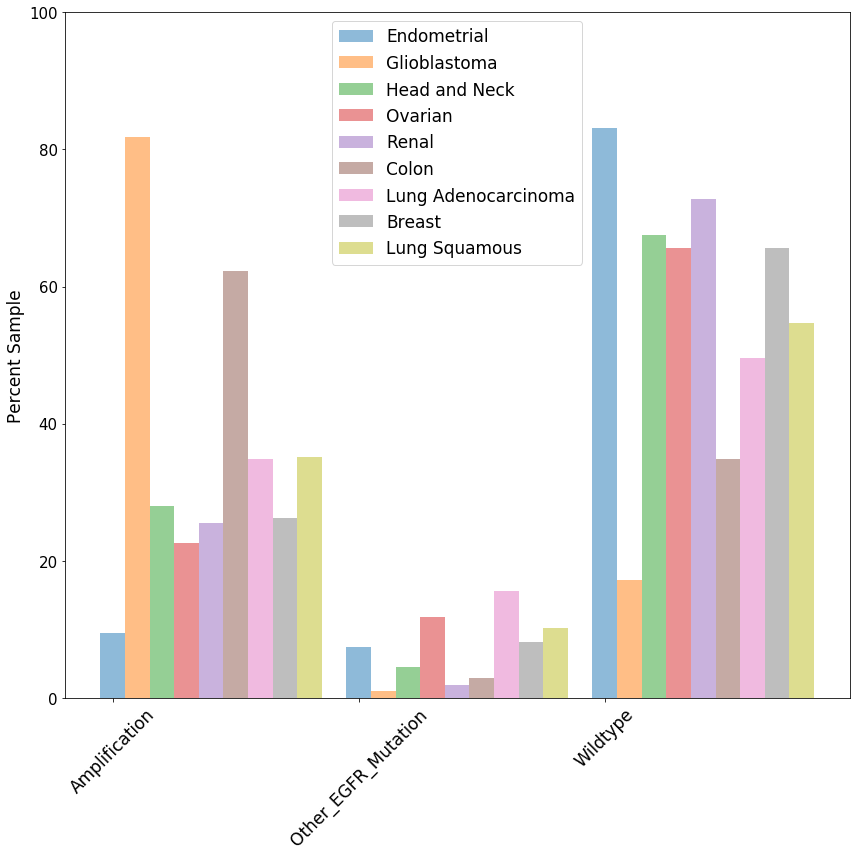

In [129]:

dfs = [endo, gbm, hnscc, ovar, cc, colon, ld, brca, lscc]
names = ['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"]

i =0
for df in dfs:
    df['CNV_Mutation'] = np.where(df["CNV_Mutation"].isin(["Amplification","Wildtype"]), df['CNV_Mutation'], 'Other_EGFR_Mutation')

    i += 1

figure1_plot_mutations("EGFR","CNV_Mutation", dfs, names, save_to_path = "EGFR_amp_wt.png")

# Compound Amplification 

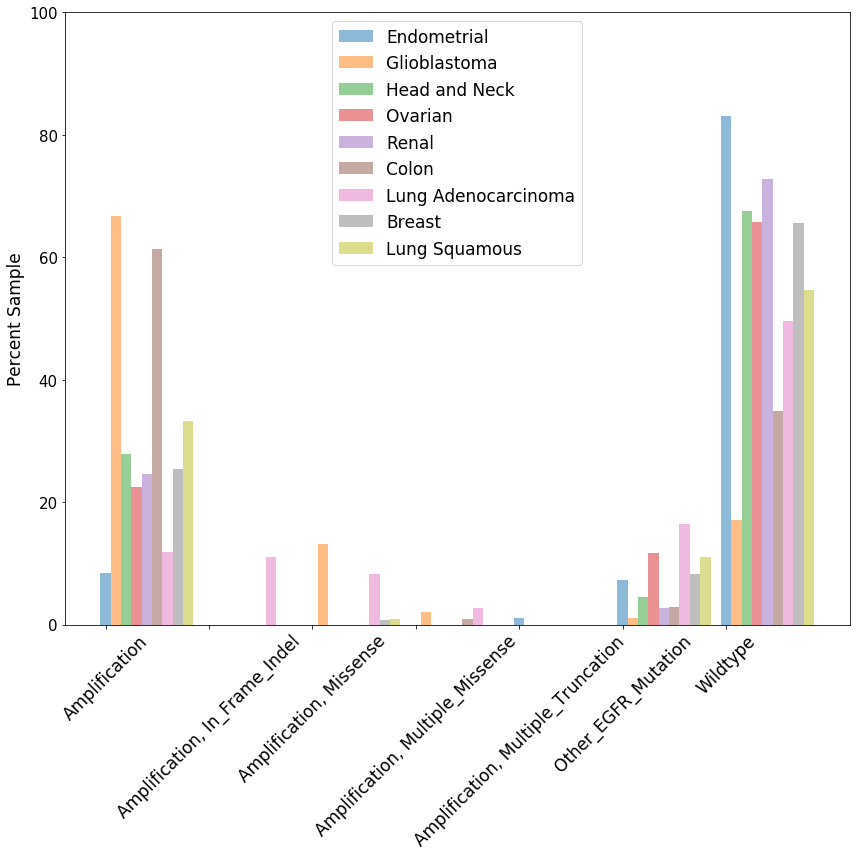

In [130]:
dfs = [endo, gbm, hnscc, ovar, cc, colon, ld, brca, lscc]
allowed_vals = ["Amplification","Amplification, In_Frame_Indel","Amplification, Missense", "Amplification, Multiple_Missense","Amplification, Multiple_Truncation","Wildtype"]

i =0
for df in dfs:
    df['All_Mutations_EGFR'] = np.where(df["All_Mutations_EGFR"].isin(allowed_vals), df['All_Mutations_EGFR'], 'Other_EGFR_Mutation')

    
names = ['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"]
figure1_plot_mutations("EGFR","All_Mutations_EGFR", dfs, names, save_to_path = "EGFR_compound_amp_wt.png")

# EGFR Amplification +PTEN

In [136]:
def find_multi_gene_multi_mut(cancer_obj,gene1,gene2):


        gene1_mutations = find_multi_cis_mut(cancer_obj,gene1)
        gene1_mutations.loc[gene1_mutations.index, 'CNV_Mutation'] = 'EGFR_' + gene1_mutations['CNV_Mutation'].astype(str)
        gene1_mutations['CNV_Mutation'] = np.where(gene1_mutations["CNV_Mutation"].isin(["EGFR_Amplification","EGFR_Wildtype"]), gene1_mutations['CNV_Mutation'], 'Other_EGFR_Mutation')
        
        gene1_mut = gene1_mutations["CNV_Mutation"]
        
        gene2_mutations = find_multi_cis_mut(cancer_obj,gene2)
        gene2_mutations["All_Mutations_"+gene2] = (gene2 + "_" + gene2_mutations["All_Mutations_"+gene2])
        gene2_mutations.loc[gene2_mutations["All_Mutations_"+ gene2] != gene2 + "_Wildtype", "All_Mutations_"+ gene2 ] = gene2 +"_Mutated"

        
        gene2_mutations = gene2_mutations["All_Mutations_"+ gene2]
        
        gene1_gene2 = pd.merge(gene1_mut, gene2_mutations, on="Patient_ID", how = "outer")
        gene1_gene2 = gene1_gene2.fillna("")
        gene1_gene2[gene1 + "_" + gene2] = gene1_gene2["CNV_Mutation"] + " " + gene1_gene2["All_Mutations_"+gene2]
        gene1_gene2.loc[gene1_gene2[gene1 + "_" + gene2] == gene1 +"_Wildtype"+ " "+ gene2 + "_Wildtype", gene1 + "_" + gene2] = "Wildtype"
      
        
        return gene1_gene2
    

In [160]:
#Run function for each cancer 
gene1 = "EGFR"
gene2 = "PTEN"
endo = find_multi_gene_multi_mut(en, gene1, gene2)
gbm = find_multi_gene_multi_mut(g, gene1, gene2)
hnscc = find_multi_gene_multi_mut(hn, gene1, gene2)
ovar = find_multi_gene_multi_mut(o, gene1,gene2)
cc = find_multi_gene_multi_mut(c, gene1, gene2)
colon = find_multi_gene_multi_mut(col, gene1, gene2)
ld = find_multi_gene_multi_mut(l, gene1, gene2)
brca = find_multi_gene_multi_mut(b, gene1, gene2)
lscc = find_multi_gene_multi_mut(ls, gene1, gene2)

dfs = [endo, gbm, hnscc, ovar, cc, colon, ld, brca, lscc]


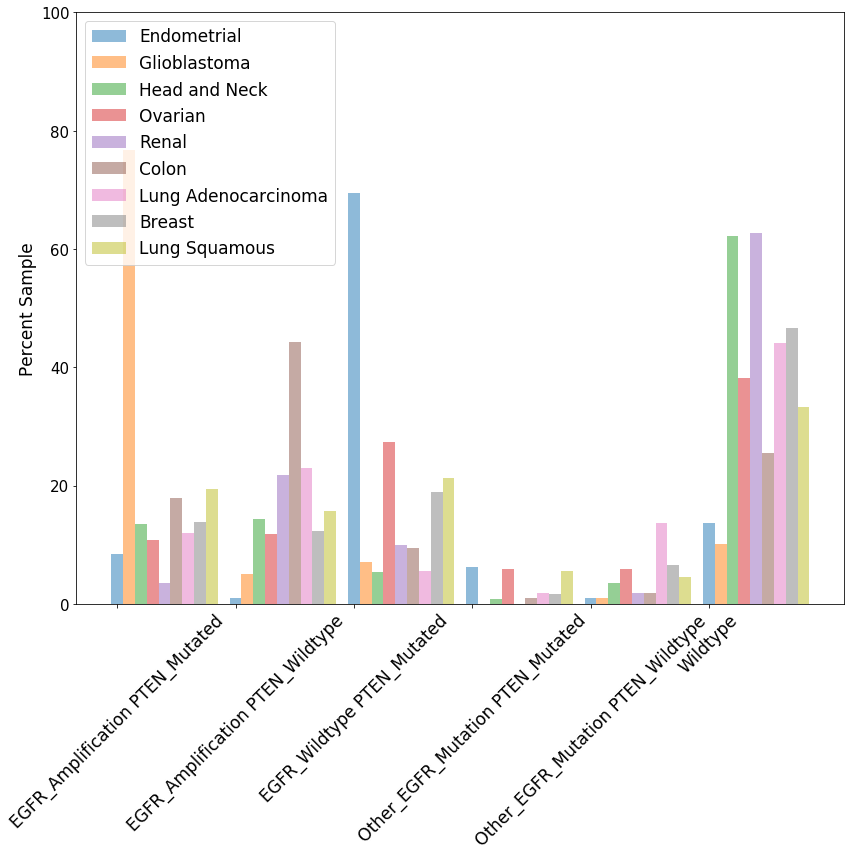

In [149]:
names = ['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"]
figure1_plot_mutations("EGFR","EGFR_PTEN", dfs, names, save_to_path = "EGFR_amp_PTEN_mut.png")

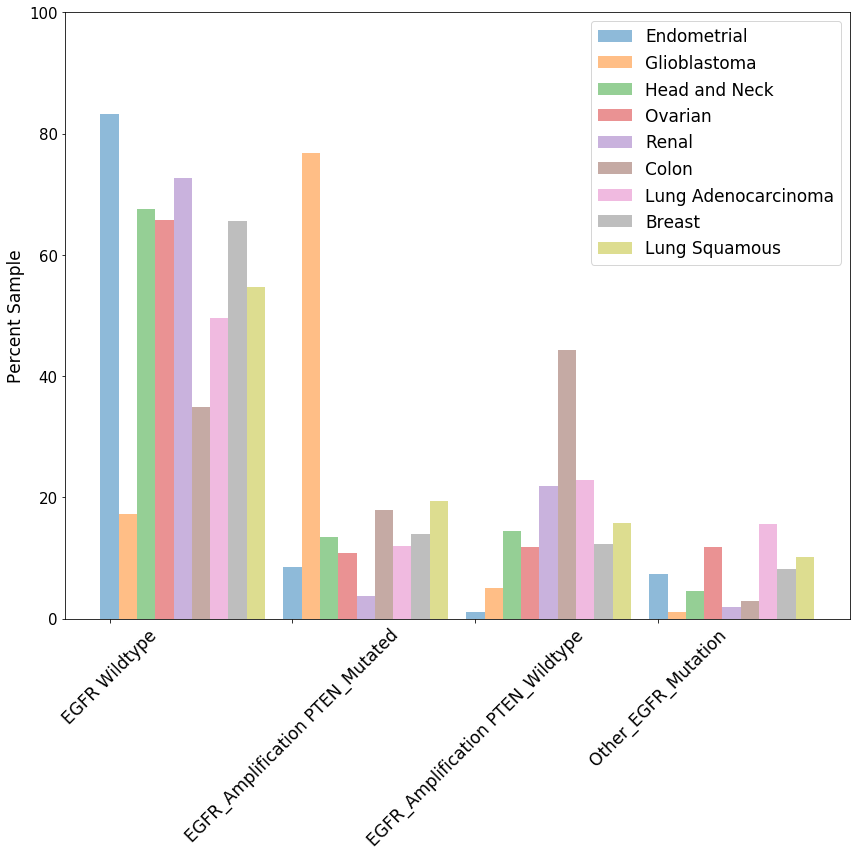

In [169]:
new_dfs = []

allowed_vals = ["Wildtype","EGFR_Amplification PTEN_Mutated","EGFR_Amplification PTEN_Wildtype"]
for df in dfs:
   
    df = df.replace(regex=r'EGFR_Wildtype PTEN_Mutated', value='Wildtype')
    df['EGFR_PTEN'] = np.where(df["EGFR_PTEN"].isin(allowed_vals), df['EGFR_PTEN'], 'Other_EGFR_Mutation')
    df = df.replace({"Wildtype": "EGFR Wildtype"})
    new_dfs.append(df)
    
names = ['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"]
figure1_plot_mutations("EGFR","EGFR_PTEN", new_dfs, names, save_to_path = "EGFR_amp_PTEN_mut_condensed.png")

# EGFR and TP53 

In [170]:
#Run function for each cancer 
gene1 = "EGFR"
gene2 = "TP53"
endo = find_multi_gene_multi_mut(en, gene1, gene2)
gbm = find_multi_gene_multi_mut(g, gene1, gene2)
hnscc = find_multi_gene_multi_mut(hn, gene1, gene2)
ovar = find_multi_gene_multi_mut(o, gene1,gene2)
cc = find_multi_gene_multi_mut(c, gene1, gene2)
colon = find_multi_gene_multi_mut(col, gene1, gene2)
ld = find_multi_gene_multi_mut(l, gene1, gene2)
brca = find_multi_gene_multi_mut(b, gene1, gene2)
lscc = find_multi_gene_multi_mut(ls, gene1, gene2)

dfs = [endo, gbm, hnscc, ovar, cc, colon, ld, brca, lscc]

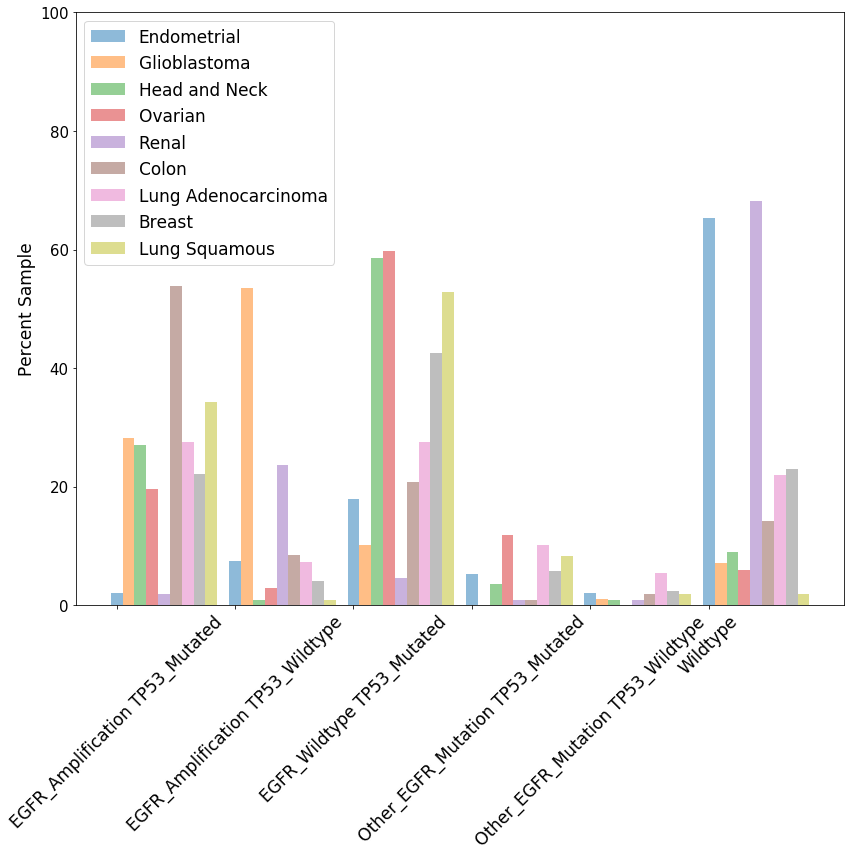

In [172]:
names = ['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"]
figure1_plot_mutations("EGFR","EGFR_TP53", dfs, names, save_to_path = "EGFR_amp_TP53_mut.png")

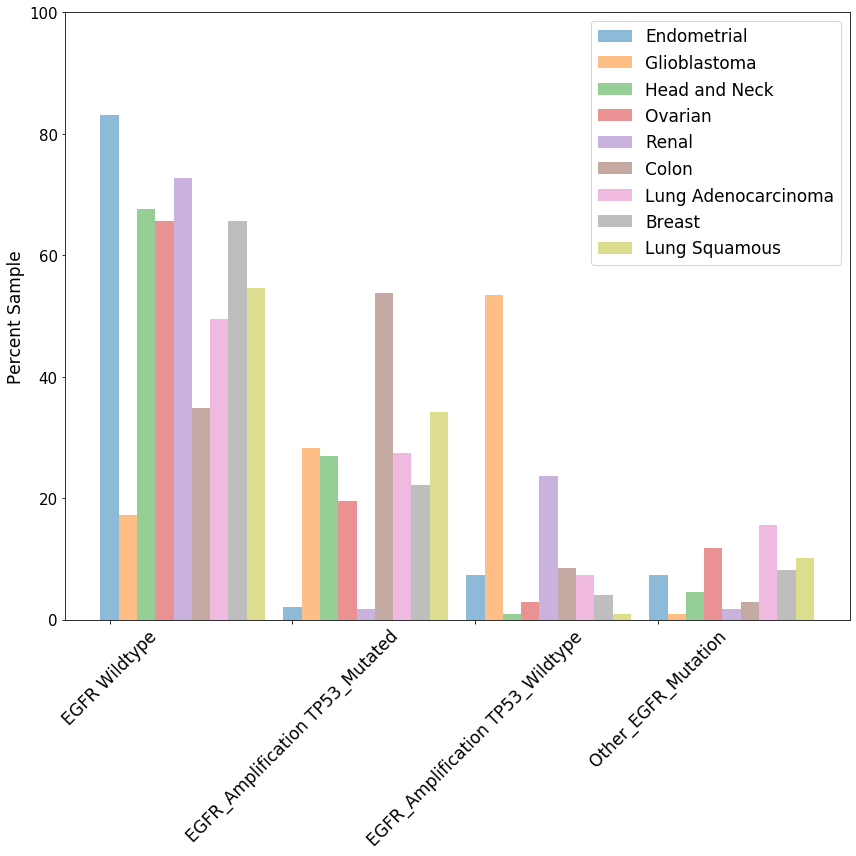

In [175]:
new_dfs = []

allowed_vals = ["Wildtype","EGFR_Amplification TP53_Mutated","EGFR_Amplification TP53_Wildtype"]
for df in dfs:
   
    df = df.replace(regex=r'EGFR_Wildtype TP53_Mutated', value='Wildtype')
    df['EGFR_PTEN'] = np.where(df["EGFR_TP53"].isin(allowed_vals), df['EGFR_TP53'], 'Other_EGFR_Mutation')
    df = df.replace({"Wildtype": "EGFR Wildtype"})
    new_dfs.append(df)
    
names = ['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"]
figure1_plot_mutations("EGFR","EGFR_PTEN", new_dfs, names, save_to_path = "EGFR_amp_TP53_mut_condensed.png")

# EGFR and PIK3CA

In [176]:
#Run function for each cancer 
gene1 = "EGFR"
gene2 = "PIK3CA"
endo = find_multi_gene_multi_mut(en, gene1, gene2)
gbm = find_multi_gene_multi_mut(g, gene1, gene2)
hnscc = find_multi_gene_multi_mut(hn, gene1, gene2)
ovar = find_multi_gene_multi_mut(o, gene1,gene2)
cc = find_multi_gene_multi_mut(c, gene1, gene2)
colon = find_multi_gene_multi_mut(col, gene1, gene2)
ld = find_multi_gene_multi_mut(l, gene1, gene2)
brca = find_multi_gene_multi_mut(b, gene1, gene2)
lscc = find_multi_gene_multi_mut(ls, gene1, gene2)

dfs = [endo, gbm, hnscc, ovar, cc, colon, ld, brca, lscc]

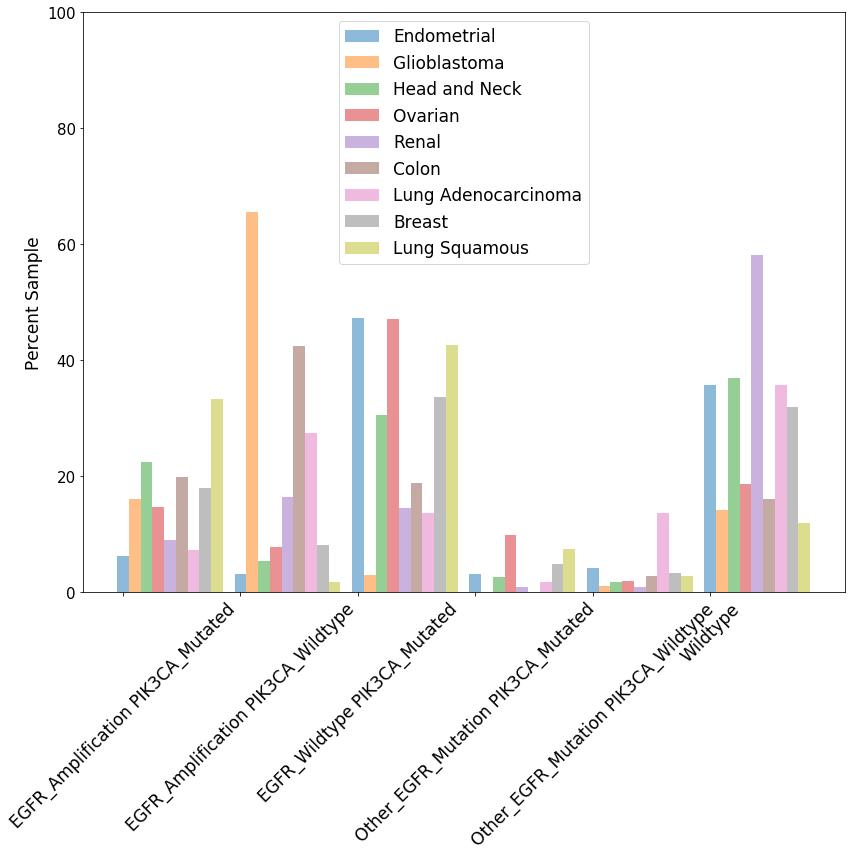

In [178]:
names = ['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"]
figure1_plot_mutations("EGFR","EGFR_PIK3CA", dfs, names, save_to_path = "EGFR_amp_PIK3CA_mut.png")

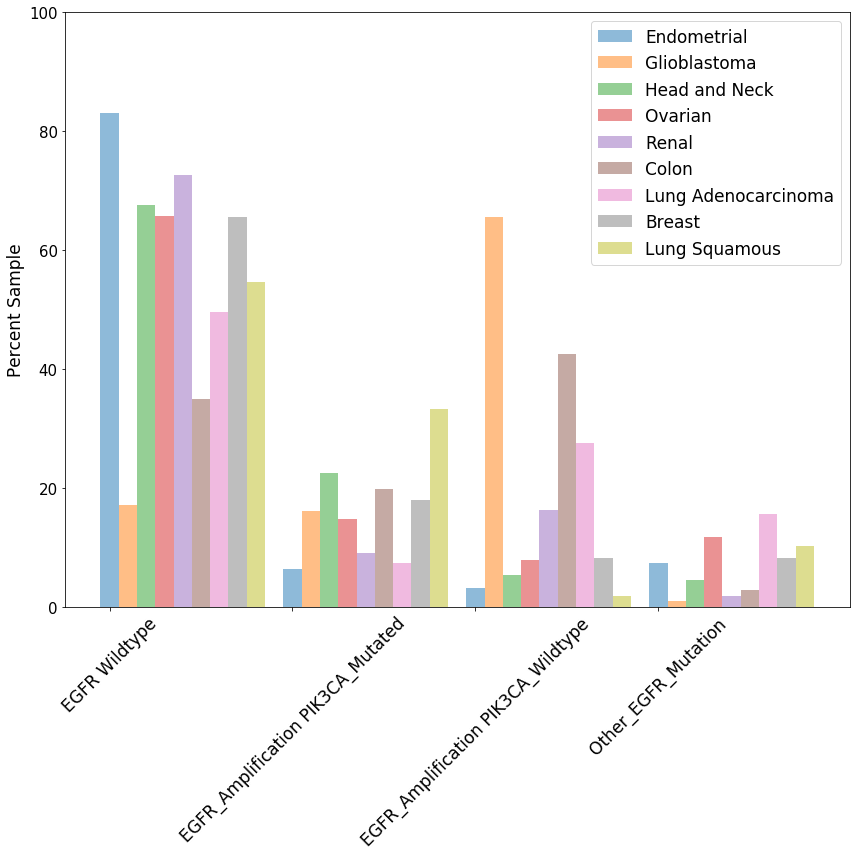

In [181]:
new_dfs = []

allowed_vals = ["Wildtype","EGFR_Amplification PIK3CA_Mutated","EGFR_Amplification PIK3CA_Wildtype"]
for df in dfs:
   
    df = df.replace(regex=r'EGFR_Wildtype PIK3CA_Mutated', value='Wildtype')
    df['EGFR_PIK3CA'] = np.where(df["EGFR_PIK3CA"].isin(allowed_vals), df['EGFR_PIK3CA'], 'Other_EGFR_Mutation')
    df = df.replace({"Wildtype": "EGFR Wildtype"})
    new_dfs.append(df)
    
names = ['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"]
figure1_plot_mutations("EGFR","EGFR_PIK3CA", new_dfs, names, save_to_path = "EGFR_amp_PIK3CA_mut_condensed.png")

# Make Figure

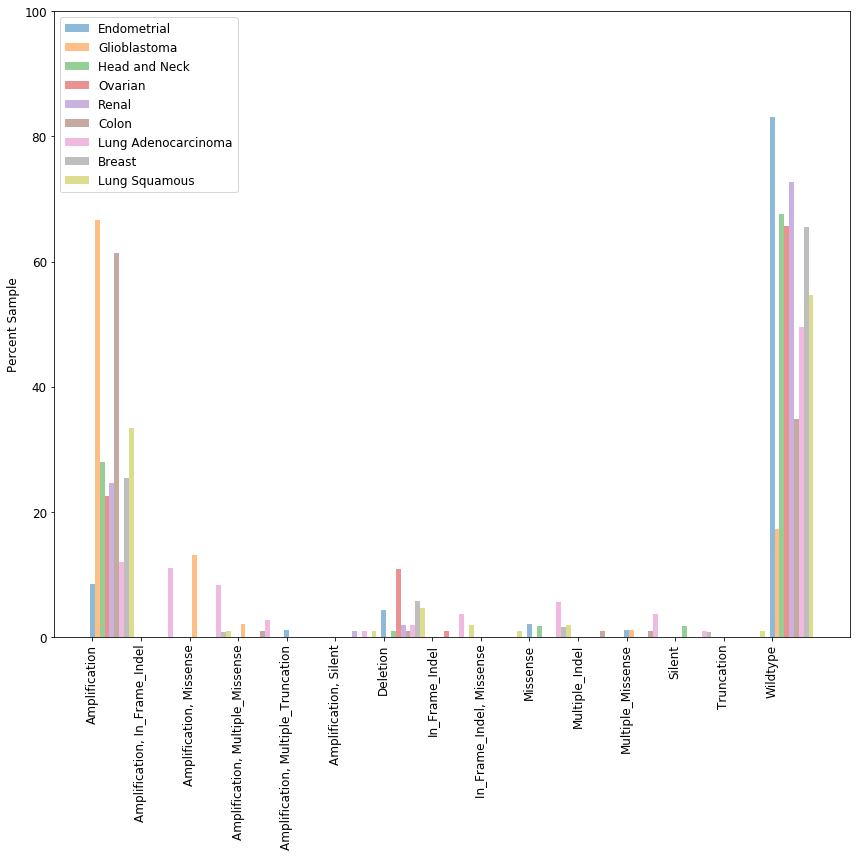

In [7]:
dfs = [endo, gbm, hnscc, ovar, cc, colon, ld, brca, lscc]
names = ['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"]
figure1_plot_mutations("EGFR","All_Mutations_EGFR", dfs, names, save_to_path = "EGFR_mult_mut.png")

# Only Amplification / WT

In [10]:
dfs = [endo, gbm, hnscc, ovar, cc, colon, ld, brca, lscc]

i =0
for df in dfs:
    dfs[i] = df[df['All_Mutations_EGFR'].isin(["Amplification","Wildtype"])]
    i += 1


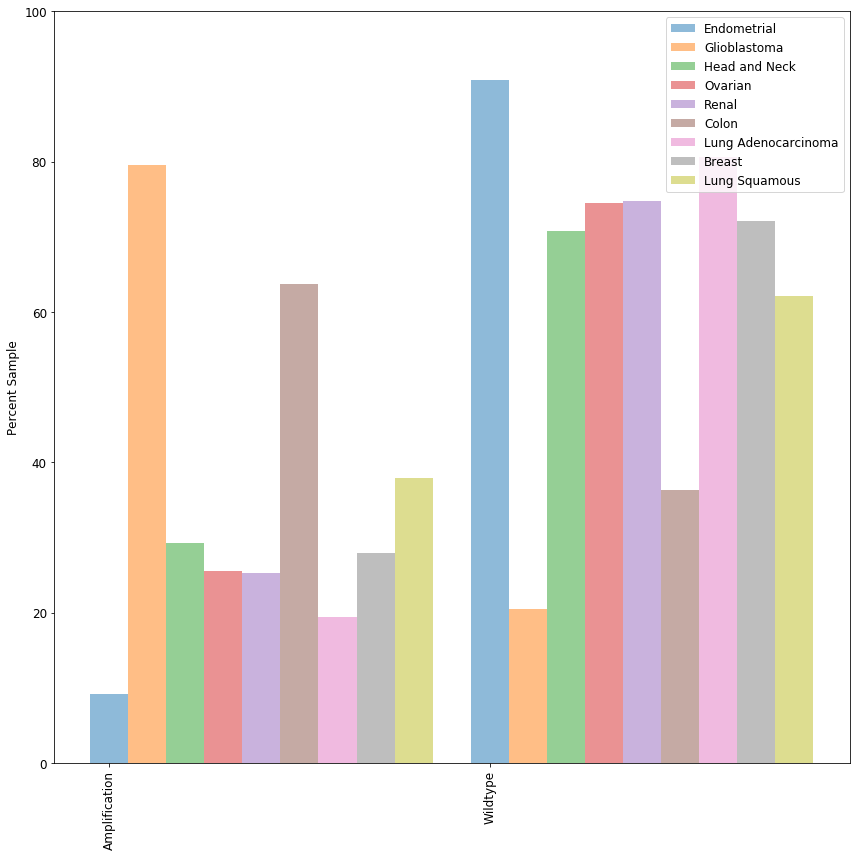

In [11]:
names = ['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"]
figure1_plot_mutations("EGFR","All_Mutations_EGFR", dfs, names, save_to_path = "EGFR_amp_wt.png")

In [12]:
def find_multi_gene_multi_mut(cancer_obj,gene1,gene2):


        gene1_mutations = find_multi_cis_mut(cancer_obj,gene1)
        gene1_mutations["All_Mutations_"+gene1] = (gene1 + "_" + gene1_mutations["All_Mutations_"+gene1])
        gene1_mutations = gene1_mutations[gene1_mutations['All_Mutations_EGFR'].isin([gene1+"_Amplification",gene1+"_Amplification, In_Frame_Indel", gene1+"_Amplification, Missense", gene1+"_Wildtype"])]
        gene1_mutations = gene1_mutations["All_Mutations_"+gene1]
        

        gene2_mutations = find_multi_cis_mut(cancer_obj,gene2)
        gene2_mutations["All_Mutations_"+gene2] = (gene2 + "_" + gene2_mutations["All_Mutations_"+gene2])
       
        gene2_mutations.loc[gene2_mutations["All_Mutations_"+ gene2] != gene2 + "_Wildtype", "All_Mutations_"+ gene2 ] = gene2 +"_Mutated"

        
        gene2_mutations = gene2_mutations["All_Mutations_"+ gene2]
        
        gene1_gene2 = pd.merge(gene1_mutations, gene2_mutations, on="Patient_ID", how = "outer")
        gene1_gene2 = gene1_gene2.fillna("")
        gene1_gene2[gene1 + "_" + gene2] = gene1_gene2["All_Mutations_"+gene1] + " " + gene1_gene2["All_Mutations_"+gene2]
        gene1_gene2.loc[gene1_gene2[gene1 + "_" + gene2] == gene1 +"_Wildtype"+ " "+ gene2 + "_Wildtype", gene1 + "_" + gene2] = "Wildtype"
      
        
        return gene1_gene2

In [13]:
#Run function for each cancer 
gene1 = "EGFR"
gene2 = "PTEN"
endo = find_multi_gene_multi_mut(en, gene1, gene2)
gbm = find_multi_gene_multi_mut(g, gene1, gene2)
hnscc = find_multi_gene_multi_mut(hn, gene1, gene2)
ovar = find_multi_gene_multi_mut(o, gene1,gene2)
cc = find_multi_gene_multi_mut(c, gene1, gene2)
colon = find_multi_gene_multi_mut(col, gene1, gene2)
ld = find_multi_gene_multi_mut(l, gene1, gene2)
brca = find_multi_gene_multi_mut(b, gene1, gene2)
lscc = find_multi_gene_multi_mut(ls, gene1, gene2)

dfs = [endo, gbm, hnscc, ovar, cc, colon, ld, brca, lscc]


,All_Mutations_EGFR,All_Mutations_PTEN,EGFR_PTEN
Patient_ID,,,
C3L-00006,EGFR_Wildtype,PTEN_Mutated,EGFR_Wildtype PTEN_Mutated
C3L-00008,EGFR_Wildtype,PTEN_Mutated,EGFR_Wildtype PTEN_Mutated
C3L-00032,EGFR_Wildtype,PTEN_Mutated,EGFR_Wildtype PTEN_Mutated
C3L-00090,EGFR_Wildtype,PTEN_Mutated,EGFR_Wildtype PTEN_Mutated
C3L-00098,EGFR_Wildtype,PTEN_Wildtype,Wildtype
...,...,...,...
C3N-01346,,PTEN_Wildtype,PTEN_Wildtype
C3L-01257,,PTEN_Mutated,PTEN_Mutated
C3L-01744,,PTEN_Mutated,PTEN_Mutated


In [14]:
dfs = [endo, gbm, hnscc, ovar, cc, colon, ld, brca, lscc]

i =0
allowed_vals = ["Wildtype","EGFR_Amplification PTEN_Mutated","EGFR_Amplification PTEN_Wildtype"]
for df in dfs:
    df['EGFR_PTEN'] = np.where(df["EGFR_PTEN"].isin(allowed_vals), df['EGFR_PTEN'], 'Other_EGFR_or_PTEN_Mutation')

    i += 1

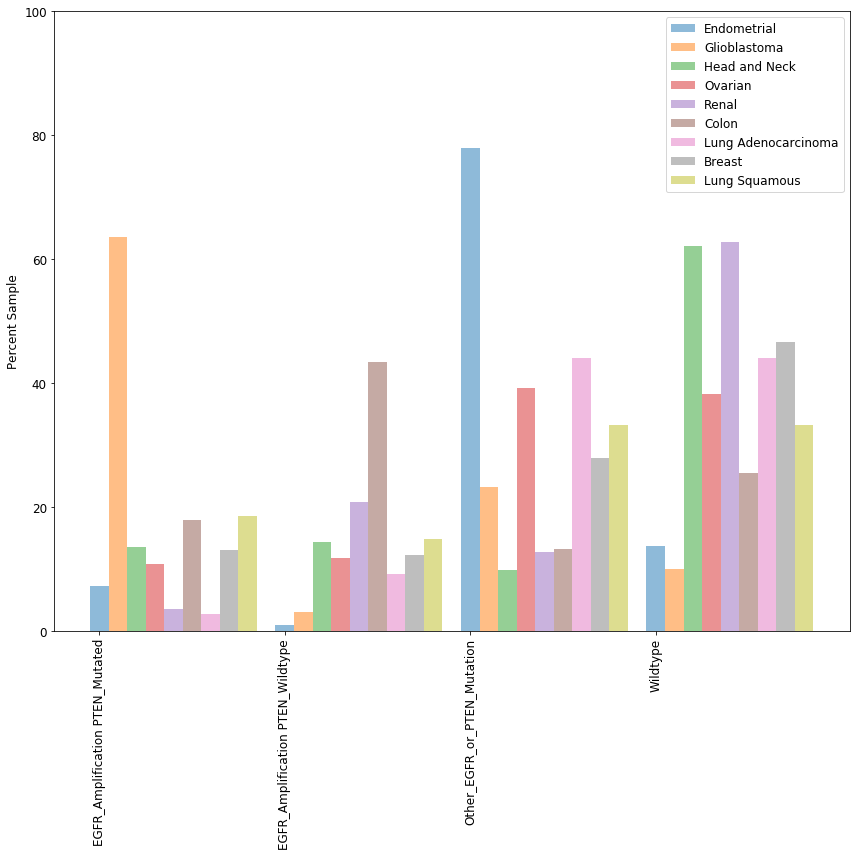

In [15]:
names = ['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"]
figure1_plot_mutations("EGFR","EGFR_PTEN", dfs, names, save_to_path = "EGFR_amp_PTEN_mut.png")

# Multiple Gene Mutations

In [16]:
#Select the cancers that you would like to test and add cptac data into a dictionary

def find_multi_gene_multi_mut(cancer_obj,gene1,gene2, cancer_name):


    gene1_mutations = find_multi_cis_mut(cancer_obj,gene1)
    gene1_mutations["All_Mutations_"+gene1] = (gene1 + "_" + gene1_mutations["All_Mutations_"+gene1])
    gene1_mutations = gene1_mutations["All_Mutations_"+gene1]

    gene2_mutations = find_multi_cis_mut(cancer_obj,gene2)

    gene2_mutations["All_Mutations_"+gene2] = (gene2 + "_" + gene2_mutations["All_Mutations_"+gene2])
    gene2_mutations = gene2_mutations["All_Mutations_"+ gene2]

    gene1_gene2 = pd.merge(gene1_mutations, gene2_mutations, on="Patient_ID", how = "outer")
    gene1_gene2[gene1 + "_" + gene2] = gene1_gene2["All_Mutations_"+gene1] + " " + gene1_gene2["All_Mutations_"+gene2]
    gene1_2_counts = gene1_gene2[gene1 + "_" + gene2].value_counts()
    gene1_2_counts = gene1_2_counts.rename(cancer_name)
    return gene1_2_counts

# EGFR and PTEN mutations 

In [17]:
#Run function for each cancer 
gene1 = "EGFR"
gene2 = "PTEN"
endo = find_multi_gene_multi_mut(en, gene1, gene2,"EC")
gbm = find_multi_gene_multi_mut(g, gene1, gene2,"GBM")
hnscc = find_multi_gene_multi_mut(hn, gene1, gene2,"HNSCC")
ovar = find_multi_gene_multi_mut(o, gene1,gene2,"OV")
cc = find_multi_gene_multi_mut(c, gene1, gene2,"ccRCC")
colon = find_multi_gene_multi_mut(col, gene1, gene2,"CO")
ld = find_multi_gene_multi_mut(l, gene1, gene2,"LUAD")
brca = find_multi_gene_multi_mut(b, gene1, gene2,"BR")
lscc = find_multi_gene_multi_mut(ls, gene1, gene2,"LSCC")
lscc

EGFR_Wildtype PTEN_Wildtype                     36
EGFR_Amplification PTEN_Wildtype                16
EGFR_Wildtype PTEN_Deletion                     16
EGFR_Amplification PTEN_Deletion                15
EGFR_Wildtype PTEN_Truncation                    3
EGFR_Wildtype PTEN_Missense                      2
EGFR_Deletion PTEN_Wildtype                      2
EGFR_Deletion PTEN_Deletion                      2
EGFR_Amplification PTEN_Deletion, Truncation     2
EGFR_Amplification PTEN_Amplification            2
EGFR_In_Frame_Indel, Missense PTEN_Wildtype      1
EGFR_Deletion PTEN_Deletion, Missense            1
EGFR_Missense PTEN_Wildtype                      1
EGFR_Amplification, Silent PTEN_Deletion         1
EGFR_Amplification, Missense PTEN_Wildtype       1
EGFR_Wildtype PTEN_Deletion, Truncation          1
EGFR_Wildtype PTEN_In_Frame_Indel                1
EGFR_Missense PTEN_Amplification                 1
EGFR_In_Frame_Indel PTEN_Wildtype                1
EGFR_In_Frame_Indel PTEN_Trunca

In [18]:
pancan = gbm_counts.to_frame().join(hnscc_counts, how = "outer")
pancan = pancan.join(colon, how = "outer")
pancan = pancan.join(brca, how = "outer")
pancan = pancan.join(ld, how = "outer")
pancan = pancan.join(lscc, how = "outer")
pancan = pancan.join(cc, how = "outer")
pancan = pancan.join(ovar, how = "outer")
pancan = pancan.join(endo, how = "outer")
pancan = pancan.rename(index={ gene1 + '_Wildtype_Tumor ' + gene2+ '_Wildtype_Tumor': "Both Wildtype"})
pancan['rowCounts'] = pancan.sum(axis=1)
pancan = pancan.sort_values('rowCounts', ascending = False)
pancan = pancan.fillna("-")
pancan = pancan.drop("rowCounts", axis = 1)
pancan.head(10)

NameError: name 'gbm_counts' is not defined

# EGFR and TP53

In [ ]:
#Run function for each cancer 
gene1 = "EGFR"
gene2 = "TP53"
endo = find_multi_gene_multi_mut(en, gene1, gene2,"EC")
gbm = find_multi_gene_multi_mut(g, gene1, gene2,"GBM")
hnscc = find_multi_gene_multi_mut(hn, gene1, gene2,"HNSCC")
ovar = find_multi_gene_multi_mut(o, gene1,gene2,"OV")
cc = find_multi_gene_multi_mut(c, gene1, gene2,"ccRCC")
colon = find_multi_gene_multi_mut(col, gene1, gene2,"CO")
ld = find_multi_gene_multi_mut(l, gene1, gene2,"LUAD")
brca = find_multi_gene_multi_mut(b, gene1, gene2,"BR")
lscc = find_multi_gene_multi_mut(ls, gene1, gene2,"LSCC")


In [ ]:
pancan = gbm_counts.to_frame().join(hnscc_counts, how = "outer")
pancan = pancan.join(colon, how = "outer")
pancan = pancan.join(brca, how = "outer")
pancan = pancan.join(ld, how = "outer")
pancan = pancan.join(lscc, how = "outer")
pancan = pancan.join(cc, how = "outer")
pancan = pancan.join(ovar, how = "outer")
pancan = pancan.join(endo, how = "outer")
pancan = pancan.rename(index={ gene1 + '_Wildtype_Tumor ' + gene2+ '_Wildtype_Tumor': "Both Wildtype"})
pancan['rowCounts'] = pancan.sum(axis=1)
pancan = pancan.sort_values('rowCounts', ascending = False)
pancan = pancan.fillna("-")
pancan = pancan.drop("rowCounts", axis = 1)
pancan.head(10)